# Simultenously visualizing multiple futures

During the most important Avengers battle against Thanos, Doctor Strange decides which path to take: the only one out of 14 million which will (will it?) bring Avengers to victory.

But... how does Doctor Strange visualizes so many futures at the same time? Let's give him a hand with Python and some Data Science.

We will demonstrante how Doctor Strange was capable of visualizing all outcomes in less than a minute and deciding which path to take.

## The original work

Our work is based on [Gabriel Schade modelling of the final battle](https://gabrielschade.github.io/2019/04/04/avengers-joia-tempo-heuristica.html). The avengers fighting that last battle are: Ironman, Spiderman, Nebula, Peter Quill, Drax, Mantis and Doctor Strange.

Every round someone hits someone. Ironman hits Thanos with one of 3 strategies, then Thanos his a random avenger (1 out of 7), then its Spiderman's turn, then Thanos again. The scenarios grow exponentially: 3 * 7 * 3 * 7 * .... = 3^n * 7 ^n per full round.

The original work and implementations allows the test of a specific heuristic, which is limitating in two ways. First it would require a lot of computational power to simulate all futures. Second if it takes 2 hours for the battle to come to an end, Doctor Strange would need 2 * number_of_scenarios_tested in order to visualize all outcomes.

I will leave the description of the characters and battle dynamics to Gabriel Schade's original work.

It is also limiting since the best heuristic is to always hit with the 3-bonus and pray that Thanos will not kill an avenger soon.

## Our implementation

We will go straight to simulating all futures at the same time. The trick is to realize that not all futures are different. For example, while the first round gives the illusion that there might be 3 different outcomes, there is actually only 2. If Ironman tries to hit with 1 or 2 bonus, he doesn't leave a mark at Thanos, who keeps his health maxed. So there are only two final outcomes (66.66% with full health) and (33.33% with 450 hp).

By discretizing the futures (note that hp and battle dynamics are discrete) *we can simulate all futures at the same time*.

## Future work:

First our work can be updated to memorize the best paths, so Doctor Strange can tranverse it during the battle.

One can run a search for parameters which will find exactly which combination of thanos and heroes stats would result in 14 millions outcomes and only one where the Avengers successfully beat Thanos, better approaching the models that Doctor Strange saw during his battle.

Note that this search might result in more than one set of parameters.


## Challenges to our work

Our work can be flawed in several ways.
- the original author decided on a few avengers characters, fell free to update the model
- there was a decision on the characters stats, feel free to update the model
- there is an assumption of the battle turn based dynamics and sequence of events
- there is no loss of attack and defense power as an avenger or thanos gets hit
- we assume the universe's future is decided during that battle, not with events outside the battle
- it might be that the Avengers universe is not real and the movie does not represent real life, hence all those futures are not real futures. They might simply be a 3d plot in a jupyter notebook somewhere in a cloud.




In [0]:
class Person:
  
  def __init__(self, name, attack, defense, hp):
    self.name = name
    self.attack = attack
    self.defense = defense
    self.hp = hp
  
  def calculate_damage(self, enemy, multiplier = 1):
    attack = self.attack * multiplier
    damage = max(attack - enemy.defense, 0)
    return damage

  def single_attack(self, enemy, current_hp, multiplier):
    return max(current_hp - self.calculate_damage(enemy, multiplier), 0)
  
  def multiple_attack(self, enemy, current_hp):
    return [self.single_attack(enemy, current_hp, multiplier) for multiplier in [1,2,3]]

In [0]:
avengers = [
    # all defenses are x 4
    Person("Ironman", 90, 100*4, 250),
    Person("Spiderman", 85, 80*4, 170),
    Person("Nebula", 75, 80*4, 150),
    Person("Peter Quil",80,90*4,170),
    Person("Drax",80,100*4,170),
    Person("Mantis",40,40*4,100),
    Person("Doctor Strange",95,80*4,170)
]

In [0]:
thanos = Person("Thanos", 240*2,220,500) # all atacks are x 2

In [0]:
import imageio
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec

heroes_full_hp = sum([p.hp for p in avengers])
heroes_count = len(avengers)

class Grapher:
  
  def __init__(self):
    self.filenames = []

  def generate_data(self, situations):
    graph = np.zeros((101, 101))
    for situation, prob in situations.items():
      current_heroes = sum(situation[2:-1])
      current_thanos = situation[-1]
      graph[int(current_heroes/heroes_full_hp*100)][int(100*current_thanos/thanos.hp)] += (prob * 100)
    return graph

  def plot(self, situations, filenumber=None):
    g = self.generate_data(situations)
    print("# of outcomes", len(situations))
    print("prob sum", g.sum())
    
    
    fig = plt.figure()
    gs = GridSpec(1, 1, figure = fig)
    
    ax = fig.add_subplot(gs[0, 0], projection='3d')
    
    y = list(range(0, g.shape[0]))
    x = list(range(0, g.shape[1]))
    X, Y = np.meshgrid(x, y)
    Z = g

    # scatter to see points instead of fake surfaces
#     Z[Z <= 0.] = np.NaN
#     ax.scatter3D(X, Y, Z)

    ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
    ax.set_xlim((0, 100))
    ax.set_ylim((0, 100))
#     ax.set_zlim((0, 100)) # optional to make them easier to compae

    ax.set_xlabel('thanos')
    ax.set_ylabel('avengers')
    ax.set_zlabel('prob');
    ax.set_title('% avengers hp x thanos hp')

    if filenumber:
      filename = "avengers-{}.png".format(filenumber)
      plt.savefig(filename)
      self.filenames.append(filename)
      fig.suptitle("Round {}".format(filenumber))
    else:
      fig.suptitle("Single round")

    plt.show()

  def animate(self):
    images = []
    for filename in self.filenames:
        images.append(imageio.imread(filename))
    imageio.mimsave('avengers.gif', images)

(101, 101)
# of outcomes 3
prob sum 100.0


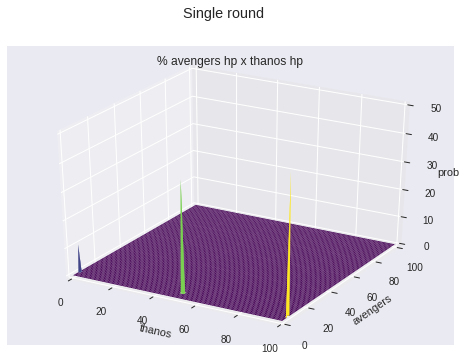

In [5]:
# testing the graph

test_data = {
        (0,'heroes',10,10,10,10,10,10,thanos.hp) : 0.5,
        (0,'heroes',10,15,10,15,10,15,thanos.hp/2) : 0.4,
        (0,'heroes',10,15,10,15,10,0,0) : 0.1
       }
g = Grapher()
print(g.generate_data(test_data).shape)
g.plot(test_data)

In [0]:
from collections import defaultdict

class Game:
  
  def __init__(self, avengers, thanos):
    self.round = 0
    first_round = [h.hp for h in avengers]
    first_round = tuple([0, "avengers", *first_round, thanos.hp])
    self.situations = {first_round : 1}
    
  def simulate(self, situation, prob, new_situations):

      hps = situation[2:-1]

      # avengers died, thanos won
      if sum(hps) <= 0: 
        t = [0,'thanos', *situation[2:]]
        new_situations[tuple(t)] += prob
        return
      
      # thanos died, avengers won
      if (situation[-1] <= 0):
        t = [0,'avengers', *situation[2:]]
        new_situations[tuple(t)] += prob
        return

      avenger_id = situation[0]
      if situation[1]=='avengers':
        avenger = avengers[avenger_id]

        # avenger is already dead, ignore his/her turn and thanos too
        if situation[avenger_id+2] <= 0:
          next_one = (avenger_id + 1) % len(avengers)
          t = [next_one, 'avengers', *situation[2:]]
          new_situations[tuple(t)] += prob
          return

        # avenger alive and well
        results = avenger.multiple_attack(thanos, situation[-1])
        for resulting_hp in results:
          t = [avenger_id, 'thanos', *situation[2:-1], resulting_hp]
          new_situations[tuple(t)] += prob / 3
        return

      # thanos will try to attack
      next_one = (avenger_id + 1) % len(avengers)

      alive = [hp > 0 for hp in hps]
      total_alive = sum(alive)
      
      for i, is_alive in enumerate(alive):
        if is_alive:
          new_hp = max(situation[i+2] - thanos.calculate_damage(avengers[i], 1),0)
          resulting_hps = [*situation[2:i+2], new_hp, *situation[i+3:]]
          t = [next_one, 'avengers', *resulting_hps]
          new_situations[tuple(t)] += prob / total_alive
  
  def next_round(self):
    self.round += 1
    print("round {} with {} starting conditions".format(self.round, len(self.situations)))
    
    new_situations = defaultdict(int)
    for situation, prob in self.situations.items():
      self.simulate(situation, prob, new_situations)

    self.situations = new_situations
    
  def play_rounds(self, n, verbose_each = 30):
    graph = Grapher()
    for rt in range(n):
      self.next_round()
      if self.round % verbose_each == 0:
        graph.plot(self.situations, filenumber = rt)
    graph.animate()

  def print_odds(self):
    odds_thanos = 0
    odds_avengers = 0
    for p1, prob  in self.situations.items():
      if p1[-1] == 0:
        odds_avengers += prob
      if sum(p1[2:-1]) == 0:
        odds_thanos += prob
    print("thanos {:.8f}% avengers {:.8f}%".format(odds_thanos * 100, odds_avengers * 100))


round 1 with 1 starting conditions
round 2 with 2 starting conditions
round 3 with 14 starting conditions
round 4 with 28 starting conditions
round 5 with 104 starting conditions
round 6 with 184 starting conditions
round 7 with 584 starting conditions
round 8 with 1118 starting conditions
round 9 with 2314 starting conditions
round 10 with 3413 starting conditions
round 11 with 5173 starting conditions
round 12 with 5864 starting conditions
round 13 with 11430 starting conditions
round 14 with 17285 starting conditions
round 15 with 25243 starting conditions
round 16 with 30906 starting conditions
round 17 with 36182 starting conditions
round 18 with 39213 starting conditions
round 19 with 45937 starting conditions
round 20 with 47692 starting conditions
round 21 with 53601 starting conditions
round 22 with 50836 starting conditions
round 23 with 50406 starting conditions
round 24 with 48195 starting conditions
round 25 with 48557 starting conditions
round 26 with 44874 starting condi

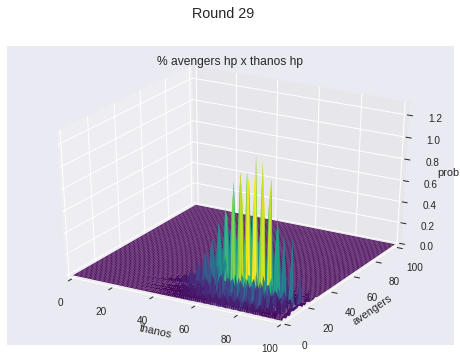

round 31 with 24233 starting conditions
round 32 with 20498 starting conditions
round 33 with 18525 starting conditions
round 34 with 16548 starting conditions
round 35 with 13551 starting conditions
round 36 with 11122 starting conditions
round 37 with 9416 starting conditions
round 38 with 8601 starting conditions
round 39 with 7387 starting conditions
round 40 with 6200 starting conditions
round 41 with 5629 starting conditions
round 42 with 4932 starting conditions
round 43 with 3981 starting conditions
round 44 with 3248 starting conditions
round 45 with 2759 starting conditions
round 46 with 2604 starting conditions
round 47 with 2157 starting conditions
round 48 with 1782 starting conditions
round 49 with 1684 starting conditions
round 50 with 1504 starting conditions
round 51 with 1247 starting conditions
round 52 with 1146 starting conditions
round 53 with 1046 starting conditions
round 54 with 950 starting conditions
round 55 with 864 starting conditions
round 56 with 763 sta

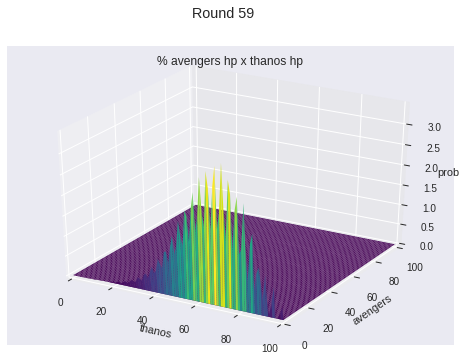

round 61 with 375 starting conditions
round 62 with 377 starting conditions
round 63 with 376 starting conditions
round 64 with 277 starting conditions
round 65 with 278 starting conditions
round 66 with 277 starting conditions
round 67 with 177 starting conditions
round 68 with 177 starting conditions
round 69 with 177 starting conditions
round 70 with 177 starting conditions


In [7]:
game = Game(avengers,thanos)
game.play_rounds(70, verbose_each=30)


In [8]:
game.print_odds()

thanos 99.99201457% avengers 0.00798543%


round 1 with 1 starting conditions
# of outcomes 2
prob sum 99.99999999999999


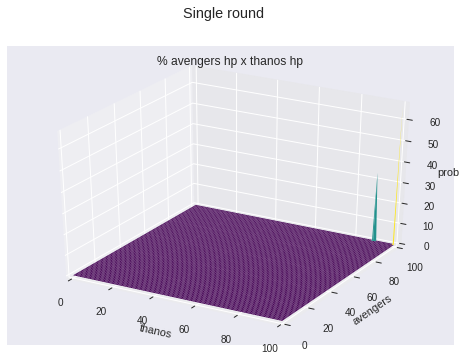

round 2 with 2 starting conditions
# of outcomes 14
prob sum 100.0


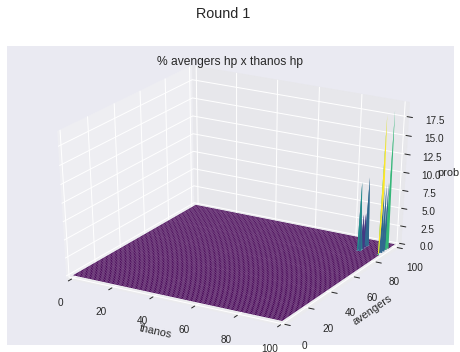

round 3 with 14 starting conditions
# of outcomes 28
prob sum 100.0


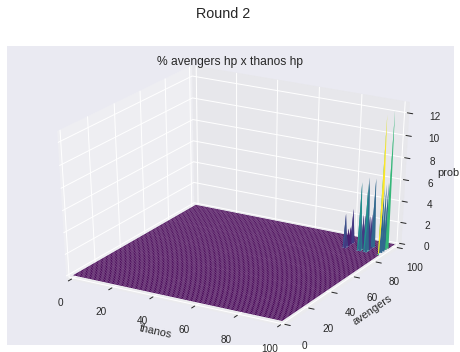

round 4 with 28 starting conditions
# of outcomes 104
prob sum 100.0


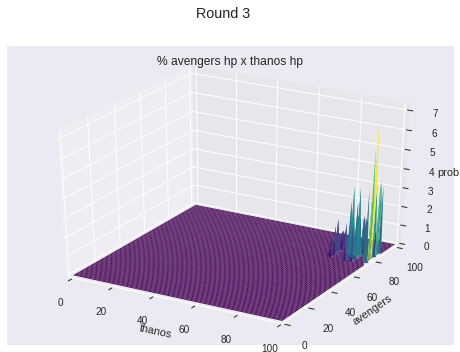

round 5 with 104 starting conditions
# of outcomes 184
prob sum 100.0


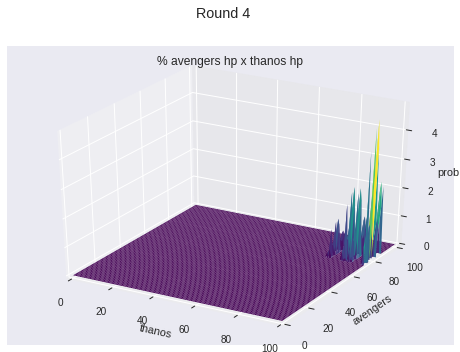

round 6 with 184 starting conditions
# of outcomes 584
prob sum 100.0


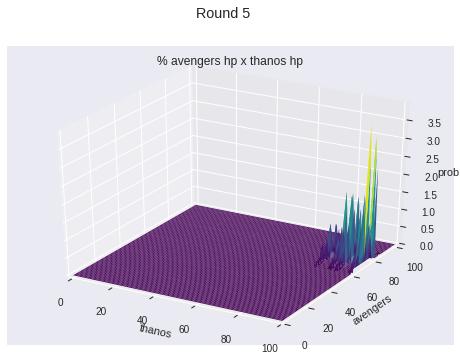

round 7 with 584 starting conditions
# of outcomes 1118
prob sum 100.0


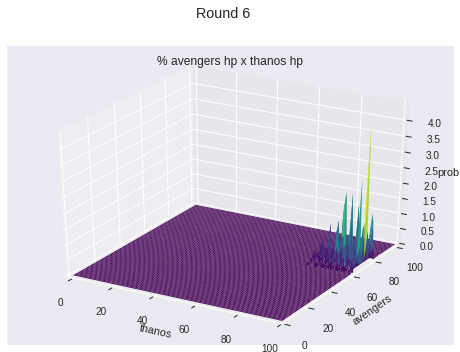

round 8 with 1118 starting conditions
# of outcomes 2314
prob sum 100.0


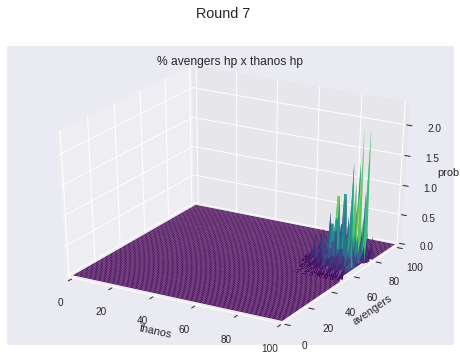

round 9 with 2314 starting conditions
# of outcomes 3413
prob sum 100.0


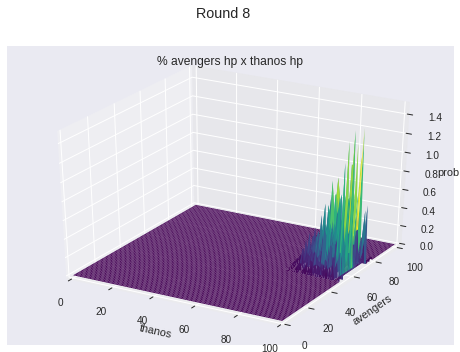

round 10 with 3413 starting conditions
# of outcomes 5173
prob sum 100.0


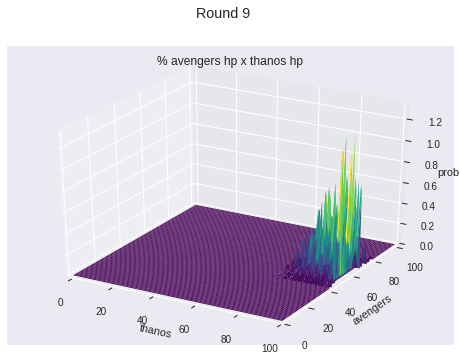

round 11 with 5173 starting conditions
# of outcomes 5864
prob sum 100.0


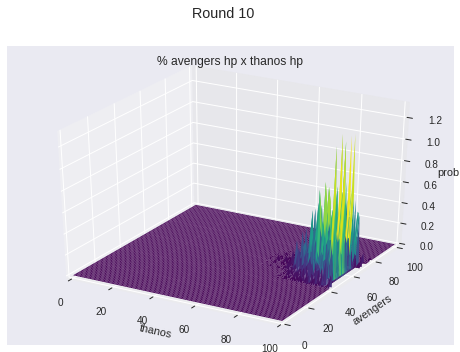

round 12 with 5864 starting conditions
# of outcomes 11430
prob sum 99.99999999999999


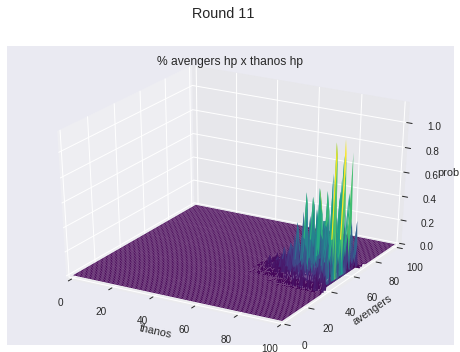

round 13 with 11430 starting conditions
# of outcomes 17285
prob sum 100.0


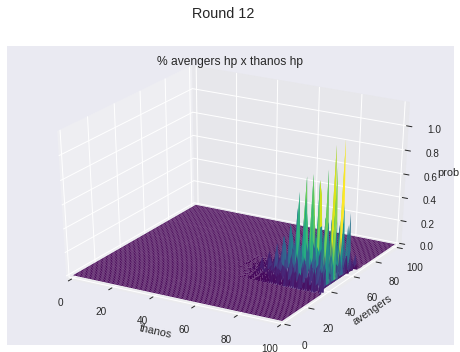

round 14 with 17285 starting conditions
# of outcomes 25243
prob sum 99.99999999999999


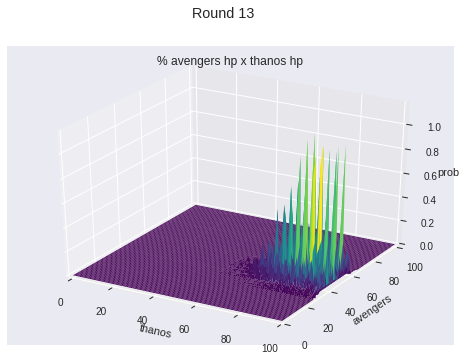

round 15 with 25243 starting conditions
# of outcomes 30906
prob sum 100.0


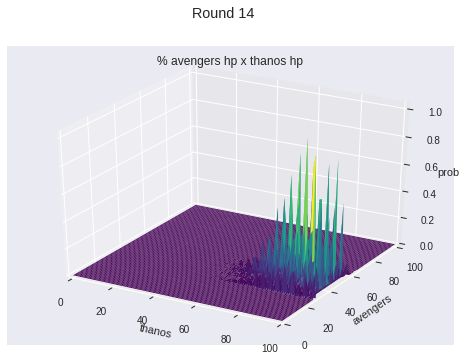

round 16 with 30906 starting conditions
# of outcomes 36182
prob sum 99.99999999999999


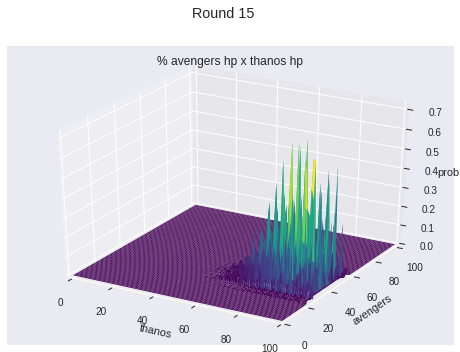

round 17 with 36182 starting conditions
# of outcomes 39213
prob sum 100.0


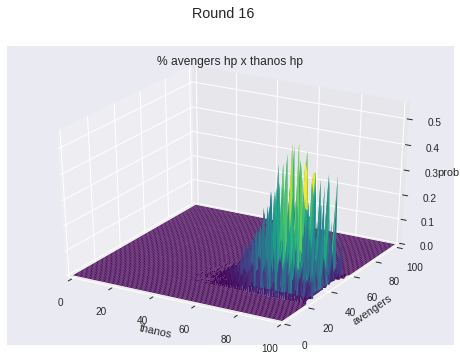

round 18 with 39213 starting conditions
# of outcomes 45937
prob sum 100.0


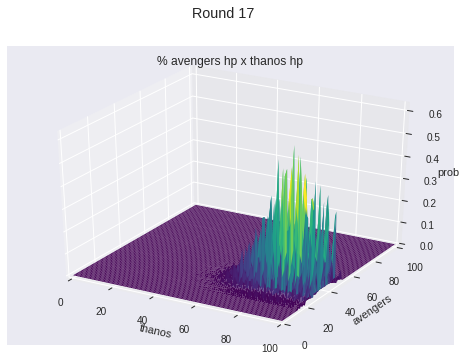

round 19 with 45937 starting conditions
# of outcomes 47692
prob sum 100.0


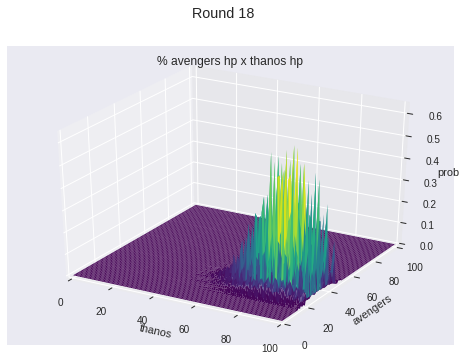

round 20 with 47692 starting conditions
# of outcomes 53601
prob sum 99.99999999999999


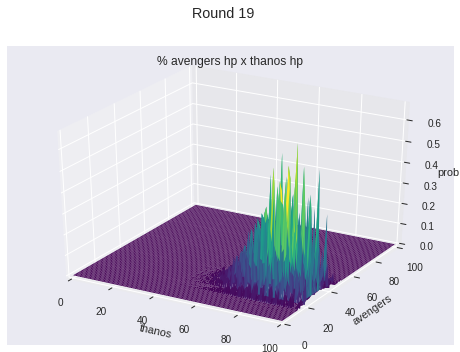

round 21 with 53601 starting conditions
# of outcomes 50836
prob sum 99.99999999999999


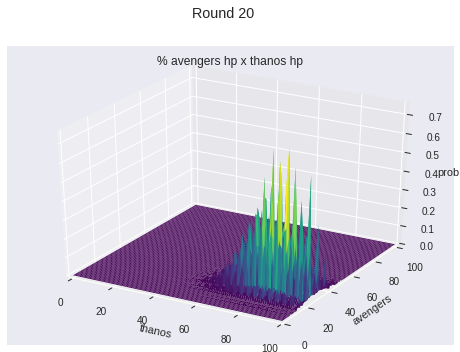

round 22 with 50836 starting conditions
# of outcomes 50406
prob sum 99.99999999999999


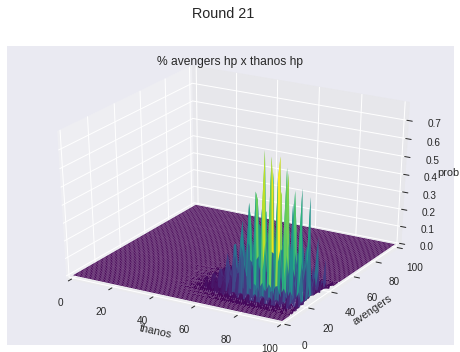

round 23 with 50406 starting conditions
# of outcomes 48195
prob sum 99.99999999999999


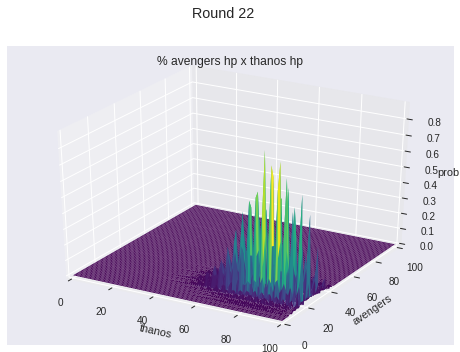

round 24 with 48195 starting conditions
# of outcomes 48557
prob sum 100.0


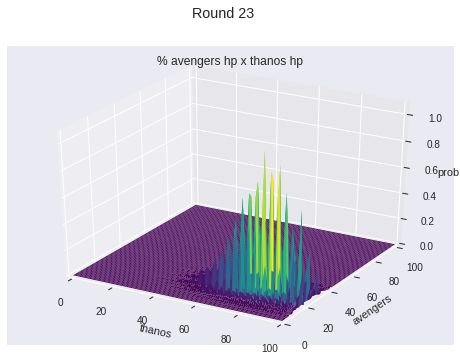

round 25 with 48557 starting conditions
# of outcomes 44874
prob sum 100.0


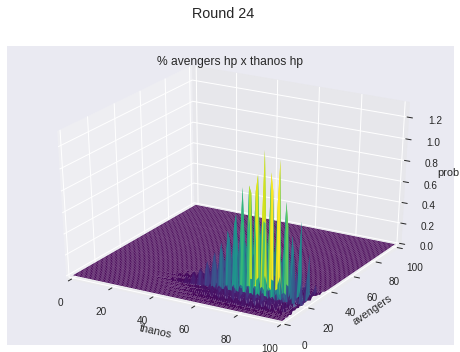

round 26 with 44874 starting conditions
# of outcomes 41092
prob sum 99.99999999999999


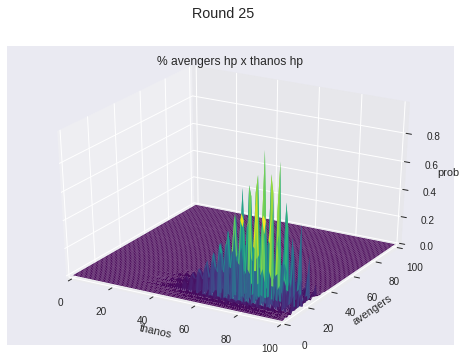

round 27 with 41092 starting conditions
# of outcomes 35665
prob sum 99.99999999999999


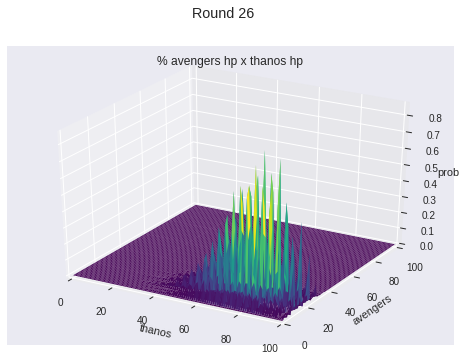

round 28 with 35665 starting conditions
# of outcomes 31904
prob sum 100.0


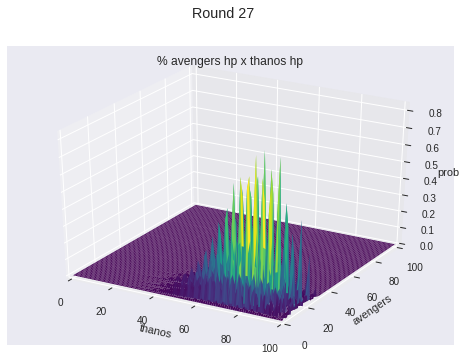

round 29 with 31904 starting conditions
# of outcomes 28037
prob sum 100.0


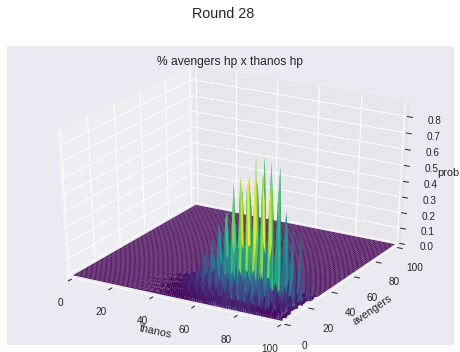

round 30 with 28037 starting conditions
# of outcomes 24233
prob sum 100.0


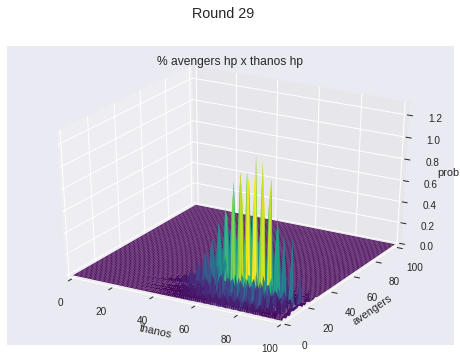

round 31 with 24233 starting conditions
# of outcomes 20498
prob sum 99.99999999999999


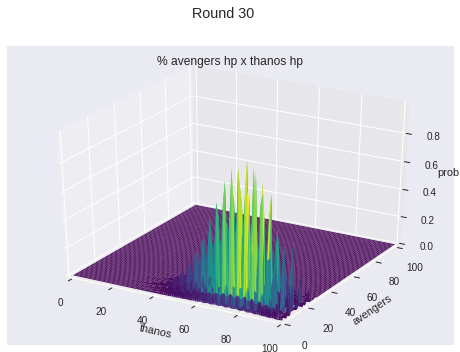

round 32 with 20498 starting conditions
# of outcomes 18525
prob sum 99.99999999999999


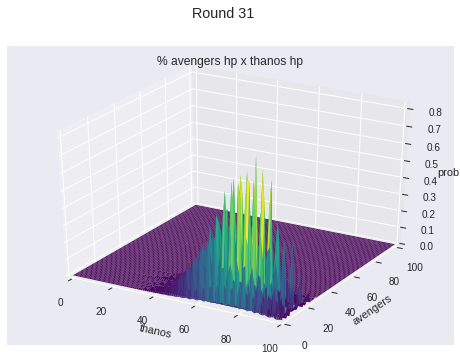

round 33 with 18525 starting conditions
# of outcomes 16548
prob sum 100.0


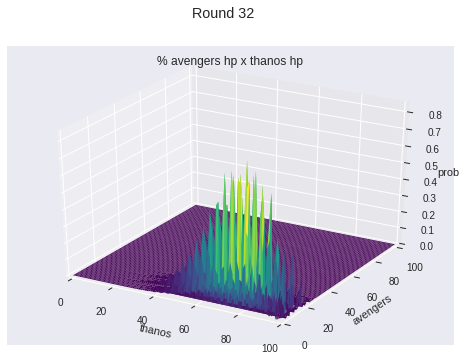

round 34 with 16548 starting conditions
# of outcomes 13551
prob sum 100.0


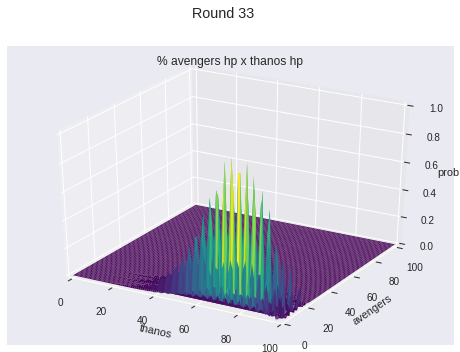

round 35 with 13551 starting conditions
# of outcomes 11122
prob sum 99.99999999999999


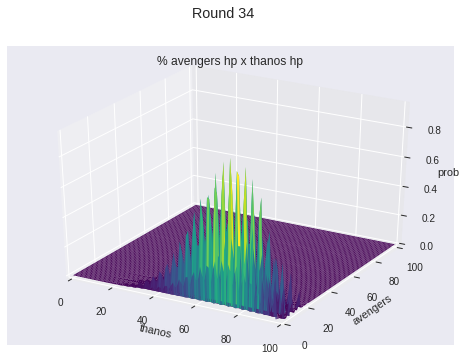

round 36 with 11122 starting conditions
# of outcomes 9416
prob sum 99.99999999999999


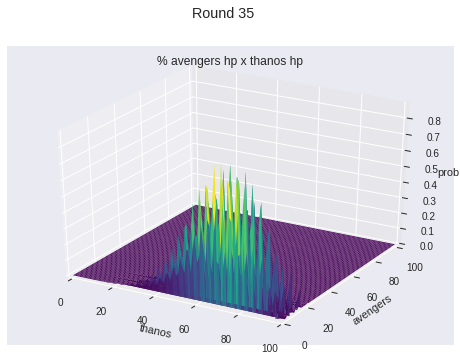

round 37 with 9416 starting conditions
# of outcomes 8601
prob sum 99.99999999999999


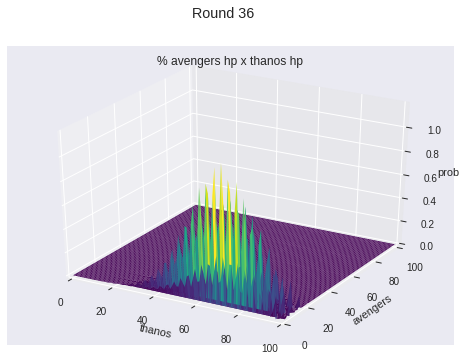

round 38 with 8601 starting conditions
# of outcomes 7387
prob sum 99.99999999999999


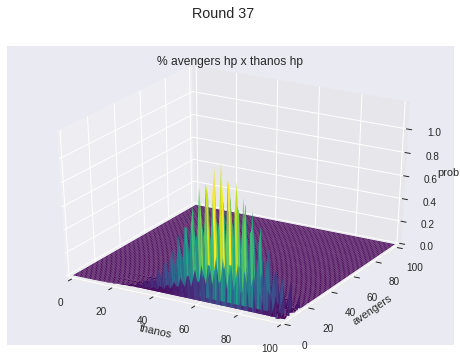

round 39 with 7387 starting conditions
# of outcomes 6200
prob sum 100.00000000000001


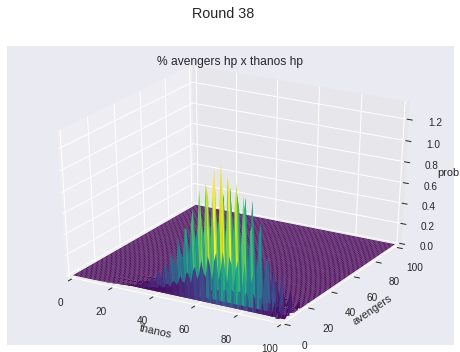

round 40 with 6200 starting conditions
# of outcomes 5629
prob sum 100.0


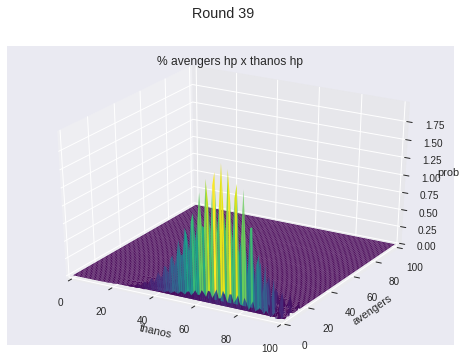

round 41 with 5629 starting conditions
# of outcomes 4932
prob sum 99.99999999999999


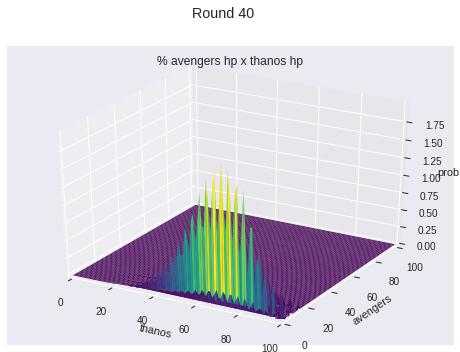

round 42 with 4932 starting conditions
# of outcomes 3981
prob sum 100.00000000000001


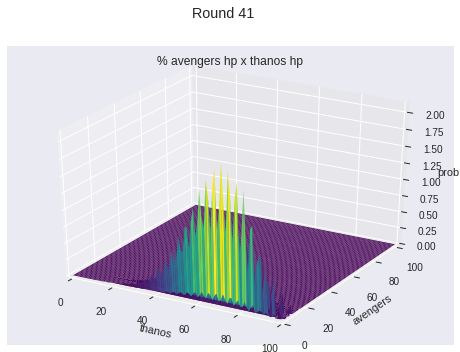

round 43 with 3981 starting conditions
# of outcomes 3248
prob sum 100.0


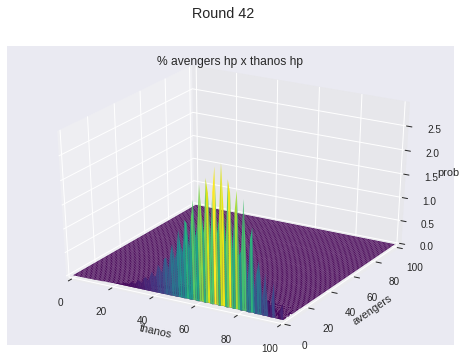

round 44 with 3248 starting conditions
# of outcomes 2759
prob sum 99.99999999999997


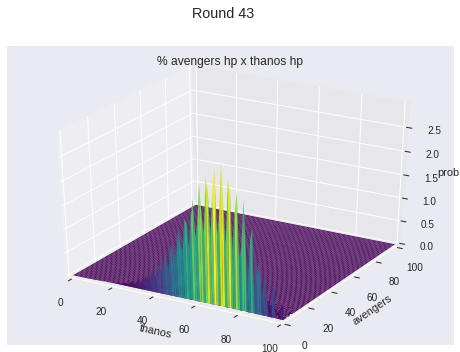

round 45 with 2759 starting conditions
# of outcomes 2604
prob sum 99.99999999999999


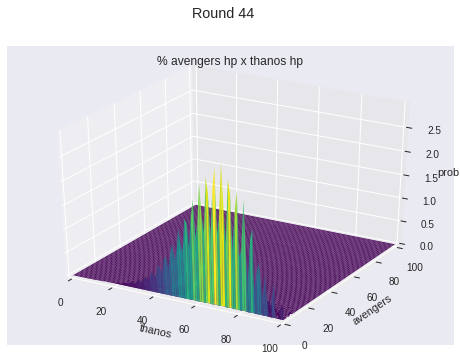

round 46 with 2604 starting conditions
# of outcomes 2157
prob sum 99.99999999999997


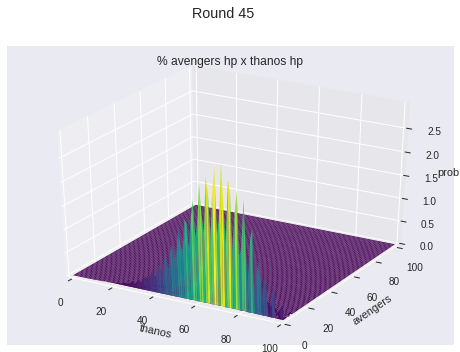

round 47 with 2157 starting conditions
# of outcomes 1782
prob sum 99.99999999999999


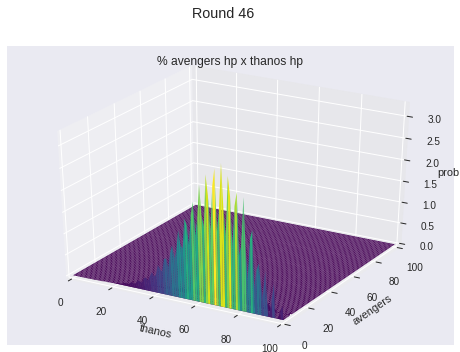

round 48 with 1782 starting conditions
# of outcomes 1684
prob sum 99.99999999999999


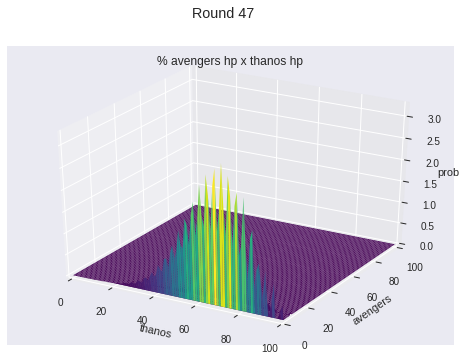

round 49 with 1684 starting conditions
# of outcomes 1504
prob sum 99.99999999999997


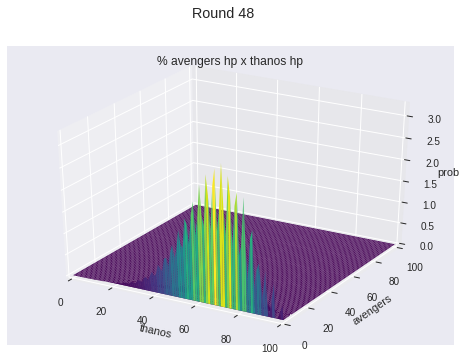

round 50 with 1504 starting conditions
# of outcomes 1247
prob sum 99.99999999999997


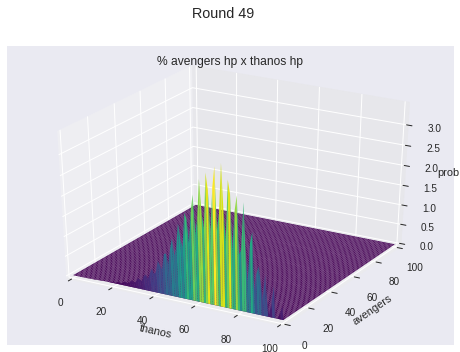

round 51 with 1247 starting conditions
# of outcomes 1146
prob sum 99.99999999999999


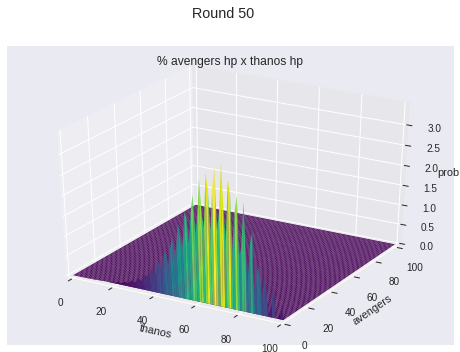

round 52 with 1146 starting conditions
# of outcomes 1046
prob sum 99.99999999999999


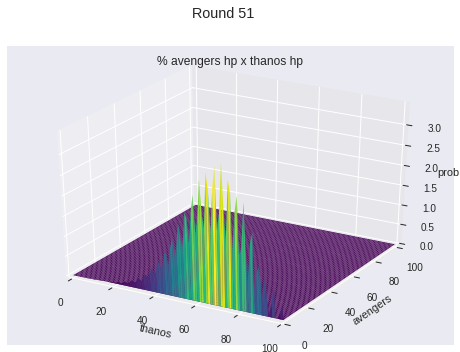

round 53 with 1046 starting conditions
# of outcomes 950
prob sum 99.99999999999999


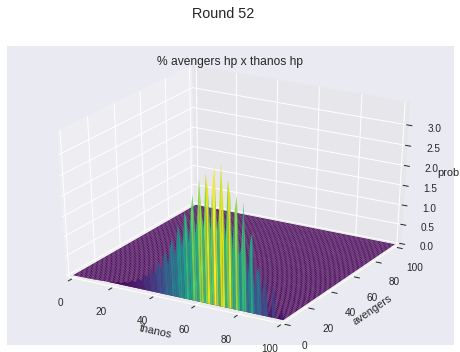

round 54 with 950 starting conditions
# of outcomes 864
prob sum 99.99999999999999


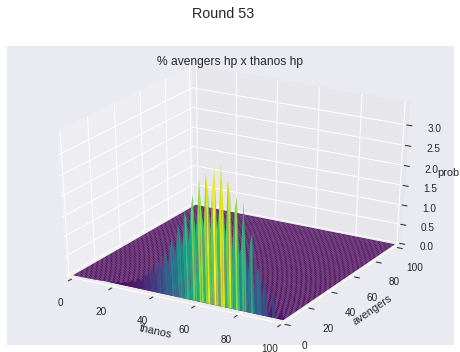

round 55 with 864 starting conditions
# of outcomes 763
prob sum 99.99999999999999


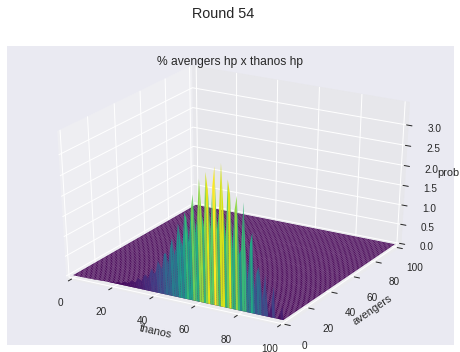

round 56 with 763 starting conditions
# of outcomes 665
prob sum 100.0


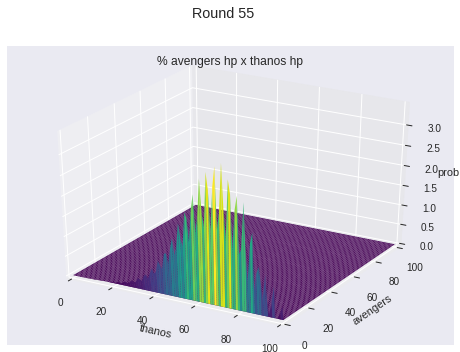

round 57 with 665 starting conditions
# of outcomes 664
prob sum 99.99999999999997


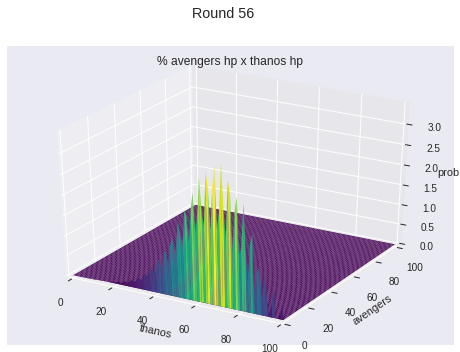

round 58 with 664 starting conditions
# of outcomes 568
prob sum 99.99999999999999


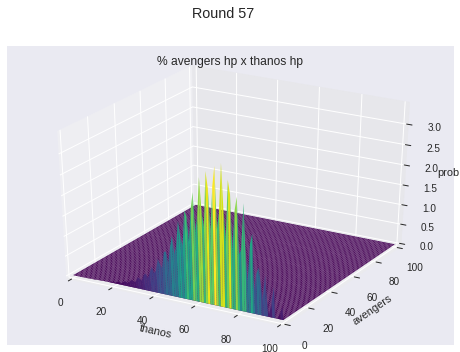

round 59 with 568 starting conditions
# of outcomes 467
prob sum 99.99999999999999


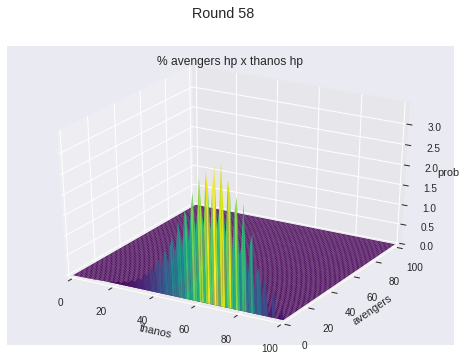

round 60 with 467 starting conditions
# of outcomes 375
prob sum 99.99999999999999


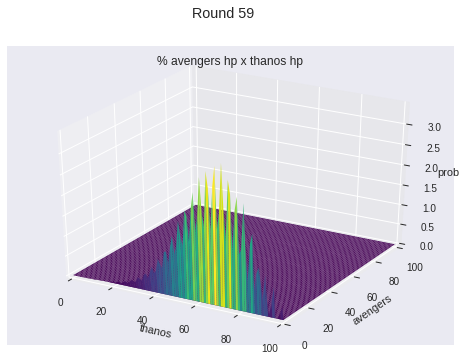

round 61 with 375 starting conditions
# of outcomes 377
prob sum 99.99999999999999


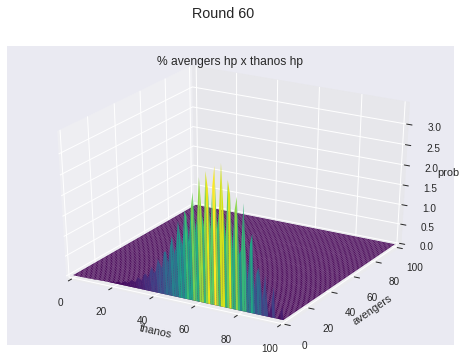

round 62 with 377 starting conditions
# of outcomes 376
prob sum 99.99999999999999


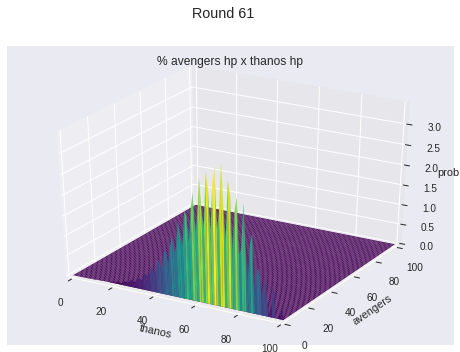

round 63 with 376 starting conditions
# of outcomes 277
prob sum 99.99999999999997


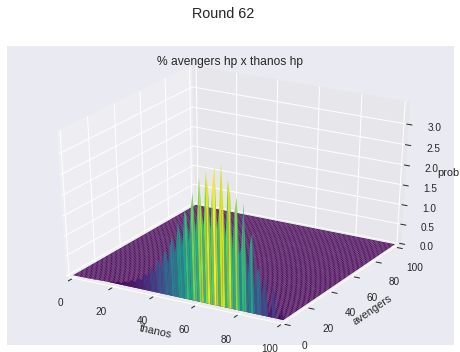

round 64 with 277 starting conditions
# of outcomes 278
prob sum 99.99999999999997


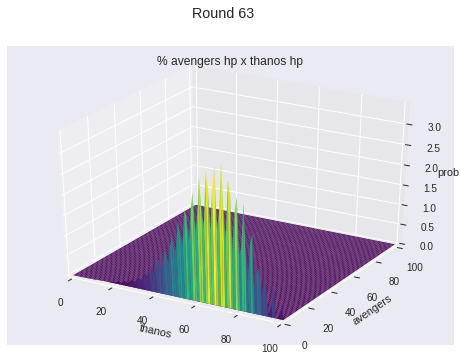

round 65 with 278 starting conditions
# of outcomes 277
prob sum 99.99999999999997


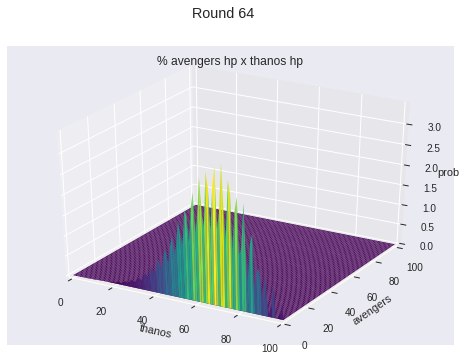

round 66 with 277 starting conditions
# of outcomes 177
prob sum 99.99999999999997


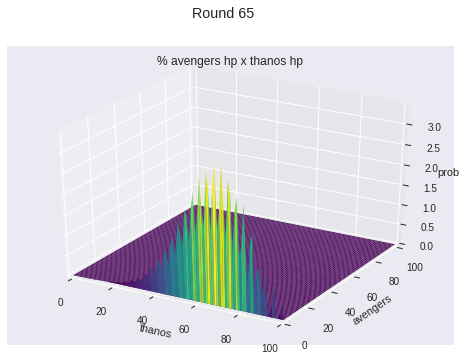

round 67 with 177 starting conditions
# of outcomes 177
prob sum 99.99999999999997


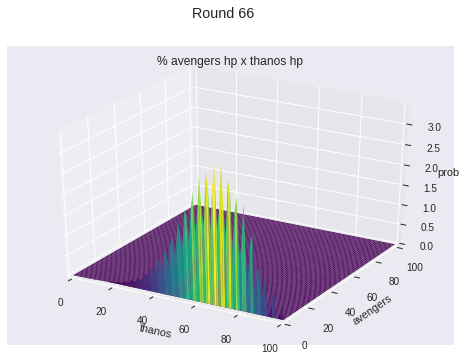

round 68 with 177 starting conditions
# of outcomes 177
prob sum 99.99999999999997


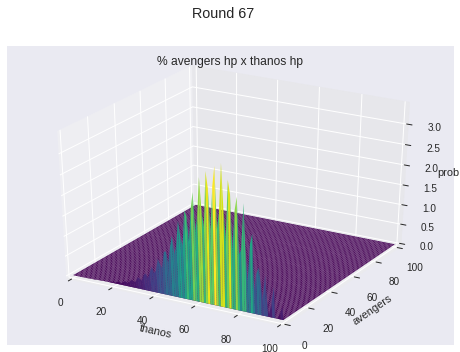

round 69 with 177 starting conditions
# of outcomes 177
prob sum 99.99999999999997


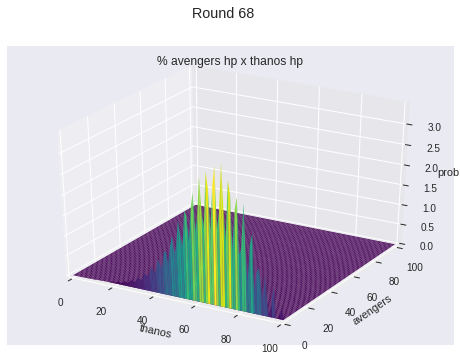

round 70 with 177 starting conditions
# of outcomes 177
prob sum 99.99999999999997


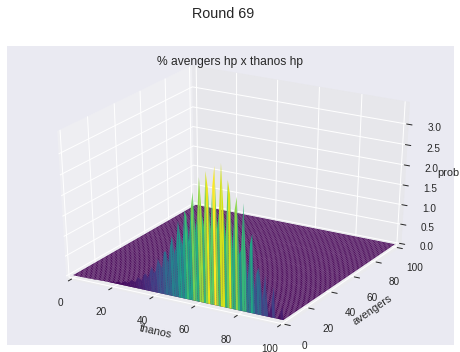

thanos 99.99201457% avengers 0.00798543%


In [9]:
game = Game(avengers,thanos)
game.play_rounds(70, verbose_each=1)
game.print_odds()